In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
def read_te_annotation(file):
    column_names = [
        "Repeat_ID",
        "Divergence",
        "Deletion",
        "Insertion",
        "Sequence_Name",
        "Alignment_Start",
        "Alignment_End",
        "Element_Length",
        "Orientation",
        "Family_Name",
        "Class",
        "Base_Count",
        "5'_Fragment_Length",
        "3'_Fragment_Length",
        "Additional_Info",
        "Repeat_Count",
        "Score"
    ]
    df = pd.read_csv(file, delim_whitespace=True, comment='#', header=None, names=column_names)
    return df

In [3]:
def extract_gene_name(attributes):
    desc = attributes.split(';')
    gene_name = desc[2].split('=')[1].lower()
    return gene_name

In [4]:
def read_gff(path, skiprows):
    gff_columns = [
    "seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"
    ]
    annotation = pd.read_csv(path, sep='\t', skiprows=9, names=gff_columns)
    annotation_filtered = annotation[annotation['type'] == 'gene']
    #for index, row in annotation_filtered.iterrows():
    #    desc = row['attributes'].split(';')
    #    gene_name = desc[2].split('=')[1].lower()
    #      annotation[index]['gene_name'] = gene_name
    annotation_filtered['gene_name'] = annotation_filtered['attributes'].apply(extract_gene_name)
    return annotation_filtered

In [5]:
def find_te_overlaps(te_df, gene_df, upstream=10000, downstream=10000):
    # Crear una lista para almacenar los resultados
    overlap_results = []

    # Iterar sobre cada gen en el DataFrame de genes
    for index, gene_row in gene_df.iterrows():
        gene_name = gene_row['gene_name']
        gene_seqid = gene_row['seqid']
        gene_start = gene_row['start']
        gene_end = gene_row['end']
        gene_strand = gene_row['strand']
        attributes = gene_row['attributes']
        # Filtrar los TEs que están en el mismo cromosoma o secuencia que el gen
        relevant_tes = te_df[te_df['Sequence_Name'] == gene_seqid]

        # Inicializar los valores para family_name, class y tipo de overlap
        te_family_name = np.nan
        te_class = np.nan
        overlap_type = np.nan

        # Buscar elementos transponibles que hagan solapamiento
        for _, te_row in relevant_tes.iterrows():
            te_start = te_row['Alignment_Start']
            te_end = te_row['Alignment_End']
            te_family = te_row['Family_Name']
            te_class_type = te_row['Class']

            # Verificar si hay solapamiento instream
            if (te_start >= gene_start and te_start <= gene_end) or (te_end >= gene_start and te_end <= gene_end):
                te_family_name = te_family
                te_class = te_class_type
                overlap_type = "instream"
                break

            # Verificar si hay solapamiento upstream
            elif (gene_start - upstream <= te_end <= gene_start):
                te_family_name = te_family
                te_class = te_class_type
                overlap_type = "upstream"
                break

            # Verificar si hay solapamiento downstream
            elif (gene_end <= te_start <= gene_end + downstream):
                te_family_name = te_family
                te_class = te_class_type
                overlap_type = "downstream"
                break

        # Agregar el resultado a la lista
        overlap_results.append({
            'gene_name': gene_name,
            'gene_start': gene_start,
            'gene_end': gene_end,
            'strand': gene_strand,
            'te_family_name': te_family_name,
            'te_class': te_class,
            'overlap_type': overlap_type,
            'attributes': attributes
        })

    # Convertir la lista de resultados en un DataFrame
    overlap_df = pd.DataFrame(overlap_results)
    return overlap_df

# Suzukii

In [6]:
suzukii_tes = read_te_annotation('ref_RepeatMaskerOCTFTA_curated.out')
suzukii_tes['Class'] = suzukii_tes['Class'].str.upper()
suzukii_tes.head()

/var/folders/fh/d7tnnq1s54x3g17lj67n05yh0000gn/T/ipykernel_4103/3938828656.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, comment='#', header=None, names=column_names)


,Repeat_ID,Divergence,Deletion,Insertion,Sequence_Name,Alignment_Start,Alignment_End,Element_Length,Orientation,Family_Name,Class,Base_Count,5'_Fragment_Length,3'_Fragment_Length,Additional_Info,Repeat_Count,Score
0,2551,5.800,2.40,0.900,NC_089019.1,33705,34037,338,C,nf_26_COPIA_1,LTR/COPIA,(352),8153,7816,33,1,No_ref_available
1,883/363,16.192,0.00,0.000,NC_089019.1,34019,34349,210,+,nf_25_CR1_1,LINE/CR1,1565,1779,(6831),34/34,2,0.024
2,519,18.300,18.10,1.200,NC_089019.1,34434,34577,168,+,nf_205_CR1_2,LINE/CR1,1763,1930,(37),36,1,0.085
3,663/225/320,13.493,15.04,2.031,NC_089019.1,41830,42408,304,+,nf_360_HELITRON_1,DNA/RC,65,640,(35),43/43/43,3,0.450
4,673,19.100,4.40,0.600,NC_089019.1,44224,44381,164,C,nf_185_TIR_2,DNA,(1962),241,78,45,1,0.074


In [7]:
suzukii_gff = read_gff('suzukii_transfer_annotation.gff', 3)
suzukii_gff.head()

/var/folders/fh/d7tnnq1s54x3g17lj67n05yh0000gn/T/ipykernel_4103/2124761365.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_filtered['gene_name'] = annotation_filtered['attributes'].apply(extract_gene_name)


,seqid,source,type,start,end,score,strand,phase,attributes,gene_name
158,NC_089019.1,Liftoff,gene,45771,48028,.,-,.,ID=gene-Dmel_CG2657;Dbxref=FLYBASE:FBgn0031209...,ir21a
168,NC_089019.1,Liftoff,gene,45771,48048,.,+,.,ID=gene-Dmel_CR43609;Dbxref=FLYBASE:FBgn026358...,asrna:cr43609
172,NC_089019.1,Liftoff,gene,49477,84204,.,-,.,ID=gene-Dmel_CG31973;Dbxref=FLYBASE:FBgn005197...,cda5
382,NC_089019.1,Liftoff,gene,78982,79518,.,+,.,ID=gene-Dmel_CR46254;Dbxref=FLYBASE:FBgn026798...,lncrna:cr46254
385,NC_089019.1,Liftoff,gene,93118,97575,.,+,.,ID=gene-Dmel_CG11371;Dbxref=FLYBASE:FBgn006777...,dbr


In [8]:
overlap_df_suzukii = find_te_overlaps(suzukii_tes, suzukii_gff)
overlap_df_suzukii.head(50)

,gene_name,gene_start,gene_end,strand,te_family_name,te_class,overlap_type,attributes
0,ir21a,45771,48028,-,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CG2657;Dbxref=FLYBASE:FBgn0031209...
1,asrna:cr43609,45771,48048,+,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CR43609;Dbxref=FLYBASE:FBgn026358...
2,cda5,49477,84204,-,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CG31973;Dbxref=FLYBASE:FBgn005197...
3,lncrna:cr46254,78982,79518,+,NaN,NaN,NaN,ID=gene-Dmel_CR46254;Dbxref=FLYBASE:FBgn026798...
4,dbr,93118,97575,+,NaN,NaN,NaN,ID=gene-Dmel_CG11371;Dbxref=FLYBASE:FBgn006777...
5,galectin,98567,101885,+,nf_47_GYPSY_1,LTR/GYPSY,downstream,ID=gene-Dmel_CG11372;Dbxref=FLYBASE:FBgn003121...
6,asrna:cr44987,98567,99694,-,NaN,NaN,NaN,ID=gene-Dmel_CR44987;Dbxref=FLYBASE:FBgn026632...
7,cg11374,102276,103548,+,nf_47_GYPSY_1,LTR/GYPSY,downstream,ID=gene-Dmel_CG11374;Dbxref=FLYBASE:FBgn003121...
8,net,112168,116649,-,nf_47_GYPSY_1,LTR/GYPSY,upstream,ID=gene-Dmel_CG11450;Dbxref=FLYBASE:FBgn000293...
9,zir,126130,133088,+,nf_23_HELITRON_1,DNA/RC,instream,ID=gene-Dmel_CG11376;Dbxref=FLYBASE:FBgn003121...


# Melanogaster

In [9]:
melanogaster_tes = read_te_annotation('MelanoRepeatMaskerOCTFTA_curated.out')
#melanogaster_tes['Class'] = melanogaster_tes['Class'].replace('LTR/GYPSY', 'LTR/Gypsy')
melanogaster_tes['Class'] = melanogaster_tes['Class'].replace('LTR/BELPAO', 'LTR/BEL-PAO')
melanogaster_tes['Class'] = melanogaster_tes['Class'].replace('DNA/TC1MARINER', 'DNA/TC1-MARINER')
melanogaster_tes['Class'] = melanogaster_tes['Class'].str.upper()
melanogaster_tes.head()

/var/folders/fh/d7tnnq1s54x3g17lj67n05yh0000gn/T/ipykernel_4103/3938828656.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, comment='#', header=None, names=column_names)


,Repeat_ID,Divergence,Deletion,Insertion,Sequence_Name,Alignment_Start,Alignment_End,Element_Length,Orientation,Family_Name,Class,Base_Count,5'_Fragment_Length,3'_Fragment_Length,Additional_Info,Repeat_Count,Score
0,385,19.700,0.900,9.200,NC_004353.4,5052,5157,98,C,nf_3_LTR_1,LTR,(2716),2290,2193,6,1,No_ref_available
1,392,19.700,0.900,9.200,NC_004353.4,11833,11938,98,C,nf_3_LTR_1,LTR,(2716),2290,2193,12,1,No_ref_available
2,56243,0.300,0.400,0.200,NC_004353.4,13649,20086,6450,+,McClintock-int,LTR/GYPSY,1,6450,(0),17,1,No_ref_available
3,2713/4343,6.539,0.633,1.236,NC_004353.4,25134,26234,965,C,1360,DNA/P,(0),3409,1,19/19,2,0.283
4,4750/5611,3.094,0.161,0.300,NC_004353.4,33824,35293,1263,+,1360,DNA/P,1,3409,(0),29/29,2,0.370


In [10]:
melanogaster_gff = read_gff('melano_annotation.gff', 8)
melanogaster_gff.head()

/var/folders/fh/d7tnnq1s54x3g17lj67n05yh0000gn/T/ipykernel_4103/2124761365.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_filtered['gene_name'] = annotation_filtered['attributes'].apply(extract_gene_name)


,seqid,source,type,start,end,score,strand,phase,attributes,gene_name
8,NC_004354.4,RefSeq,gene,122493.0,122706.0,.,+,.,ID=gene-Dmel_CR40469;Dbxref=FLYBASE:FBgn005846...,lncrna:cr40469
14,NC_004354.4,RefSeq,gene,124370.0,126714.0,.,-,.,ID=gene-Dmel_CG17636;Dbxref=FLYBASE:FBgn002583...,cg17636
37,NC_004354.4,RefSeq,gene,127449.0,140340.0,.,+,.,ID=gene-Dmel_CG40494;Dbxref=FLYBASE:FBgn002583...,rhogap1a
191,NC_004354.4,RefSeq,gene,133385.0,133502.0,.,+,.,ID=gene-Dmel_CR43552;Dbxref=FLYBASE:FBgn026356...,mir-4915
196,NC_004354.4,RefSeq,gene,140318.0,200663.0,.,+,.,ID=gene-Dmel_CG17131;Dbxref=FLYBASE:FBgn028443...,tyn


In [11]:
overlap_df_melano = find_te_overlaps(melanogaster_tes, melanogaster_gff)
overlap_df_melano.head(50)

,gene_name,gene_start,gene_end,strand,te_family_name,te_class,overlap_type,attributes
0,lncrna:cr40469,122493.0,122706.0,+,HeT-A,LINE/JOCKEY,upstream,ID=gene-Dmel_CR40469;Dbxref=FLYBASE:FBgn005846...
1,cg17636,124370.0,126714.0,-,TAHRE,LINE/JOCKEY,upstream,ID=gene-Dmel_CG17636;Dbxref=FLYBASE:FBgn002583...
2,rhogap1a,127449.0,140340.0,+,TAHRE,LINE/JOCKEY,upstream,ID=gene-Dmel_CG40494;Dbxref=FLYBASE:FBgn002583...
3,mir-4915,133385.0,133502.0,+,NaN,NaN,NaN,ID=gene-Dmel_CR43552;Dbxref=FLYBASE:FBgn026356...
4,tyn,140318.0,200663.0,+,nf_3_LTR_1,LTR,instream,ID=gene-Dmel_CG17131;Dbxref=FLYBASE:FBgn028443...
5,lncrna:cr45473,140722.0,142197.0,-,nf_3_LTR_1,LTR,downstream,ID=gene-Dmel_CR45473;Dbxref=FLYBASE:FBgn026702...
6,cg17707,142731.0,148426.0,-,nf_3_LTR_1,LTR,downstream,ID=gene-Dmel_CG17707;Dbxref=FLYBASE:FBgn002583...
7,lncrna:cr43863,151691.0,152279.0,-,nf_3_LTR_1,LTR,upstream,ID=gene-Dmel_CR43863;Dbxref=FLYBASE:FBgn026444...
8,cg3038,243954.0,245856.0,-,NaN,NaN,NaN,ID=gene-Dmel_CG3038;Dbxref=FLYBASE:FBgn0040373...
9,g9a,245978.0,254650.0,+,NaN,NaN,NaN,ID=gene-Dmel_CG2995;Dbxref=FLYBASE:FBgn0040372...


In [12]:
def compare_species_overlaps(suzukii_df, melano_df):
    # Identificar genes comunes
    common_genes = pd.merge(suzukii_df[['gene_name']], melano_df[['gene_name']], on='gene_name', how='inner')

    # Unir los DataFrames basados en el nombre del gen
    merged_df = pd.merge(suzukii_df, melano_df, on='gene_name', suffixes=('_suzukii', '_melano'))

    # Crear columnas para comparar TEs
    merged_df['te_family_diff'] = merged_df['te_family_name_suzukii'] != merged_df['te_family_name_melano']
    merged_df['te_class_diff'] = merged_df['te_class_suzukii'] != merged_df['te_class_melano']
    merged_df['overlap_type_diff'] = merged_df['overlap_type_suzukii'] != merged_df['overlap_type_melano']

    # Crear una columna indicando si hay alguna diferencia
    merged_df['has_difference'] = merged_df[['te_family_diff', 'te_class_diff', 'overlap_type_diff']].any(axis=1)

    # Eliminar filas donde no hay ningún overlap
    merged_df = merged_df.dropna(subset=['overlap_type_suzukii', 'overlap_type_melano'], how='all')

    return merged_df

In [13]:
# Usar la función
comparison_df = compare_species_overlaps(suzukii_df=overlap_df_suzukii, melano_df=overlap_df_melano)
# Mostrar las diferencias
comparison_df[comparison_df['has_difference']].head(50)

,gene_name,gene_start_suzukii,gene_end_suzukii,strand_suzukii,te_family_name_suzukii,te_class_suzukii,overlap_type_suzukii,attributes_suzukii,gene_start_melano,gene_end_melano,strand_melano,te_family_name_melano,te_class_melano,overlap_type_melano,attributes_melano,te_family_diff,te_class_diff,overlap_type_diff,has_difference
0,ir21a,45771,48028,-,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CG2657;Dbxref=FLYBASE:FBgn0031209...,21823.0,25155.0,-,NaN,NaN,NaN,ID=gene-Dmel_CG2657;Dbxref=FLYBASE:FBgn0031209...,True,True,True,True
1,asrna:cr43609,45771,48048,+,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CR43609;Dbxref=FLYBASE:FBgn026358...,21952.0,24237.0,+,NaN,NaN,NaN,ID=gene-Dmel_CR43609;Dbxref=FLYBASE:FBgn026358...,True,True,True,True
2,cda5,49477,84204,-,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CG31973;Dbxref=FLYBASE:FBgn005197...,25402.0,65404.0,-,Jockey-4_DEl,LINE/JOCKEY,instream,ID=gene-Dmel_CG31973;Dbxref=FLYBASE:FBgn005197...,True,True,True,True
3,lncrna:cr46254,78982,79518,+,NaN,NaN,NaN,ID=gene-Dmel_CR46254;Dbxref=FLYBASE:FBgn026798...,54817.0,55767.0,+,Jockey-4_DEl,LINE/JOCKEY,upstream,ID=gene-Dmel_CR46254;Dbxref=FLYBASE:FBgn026798...,True,True,True,True
4,dbr,93118,97575,+,NaN,NaN,NaN,ID=gene-Dmel_CG11371;Dbxref=FLYBASE:FBgn006777...,66482.0,71390.0,+,X-element,LINE/JOCKEY,upstream,ID=gene-Dmel_CG11371;Dbxref=FLYBASE:FBgn006777...,True,True,True,True
5,galectin,98567,101885,+,nf_47_GYPSY_1,LTR/GYPSY,downstream,ID=gene-Dmel_CG11372;Dbxref=FLYBASE:FBgn003121...,71757.0,76211.0,+,X-element,LINE/JOCKEY,upstream,ID=gene-Dmel_CG11372;Dbxref=FLYBASE:FBgn003121...,True,True,True,True
6,asrna:cr44987,98567,99694,-,NaN,NaN,NaN,ID=gene-Dmel_CR44987;Dbxref=FLYBASE:FBgn026632...,71039.0,73836.0,-,X-element,LINE/JOCKEY,upstream,ID=gene-Dmel_CR44987;Dbxref=FLYBASE:FBgn026632...,True,True,True,True
7,cg11374,102276,103548,+,nf_47_GYPSY_1,LTR/GYPSY,downstream,ID=gene-Dmel_CG11374;Dbxref=FLYBASE:FBgn003121...,76348.0,77783.0,+,NaN,NaN,NaN,ID=gene-Dmel_CG11374;Dbxref=FLYBASE:FBgn003121...,True,True,True,True
8,net,112168,116649,-,nf_47_GYPSY_1,LTR/GYPSY,upstream,ID=gene-Dmel_CG11450;Dbxref=FLYBASE:FBgn000293...,82421.0,87387.0,-,NaN,NaN,NaN,ID=gene-Dmel_CG11450;Dbxref=FLYBASE:FBgn000293...,True,True,True,True
9,zir,126130,133088,+,nf_23_HELITRON_1,DNA/RC,instream,ID=gene-Dmel_CG11376;Dbxref=FLYBASE:FBgn003121...,94739.0,102086.0,+,NaN,NaN,NaN,ID=gene-Dmel_CG11376;Dbxref=FLYBASE:FBgn003121...,True,True,True,True


In [14]:
# Supongamos que tu DataFrame se llama 'df'
comparison_df.to_csv('comparison_df.csv', index=False)

In [15]:
# Contar las diferencias
diff_counts = comparison_df['has_difference'].value_counts()
print(diff_counts)

has_difference
True    8885
Name: count, dtype: int64


In [16]:
"""
def create_heatmap(comparison_df):
    #comparison_df['suzukii_te_present'] = comparison_df['te_family_name_suzukii'].apply(lambda x: 1 if x else 0)
    comparison_df['melano_te_present'] = comparison_df['te_family_name_melano'].apply(lambda x: 1 if x else 0)

    # Crear el heatmap
    heatmap_data = comparison_df[['gene_name', 'suzukii_te_present', 'melano_te_present']]
    heatmap_data.set_index('gene_name', inplace=True)

    plt.figure(figsize=(10, 14))
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'TE Presence'})
    plt.title('TE Presence/Absence in D. suzukii and D. melanogaster Genes')
    plt.xlabel('Species')
    plt.ylabel('Genes')
    plt.show()
"""

"\ndef create_heatmap(comparison_df):\n    #comparison_df['suzukii_te_present'] = comparison_df['te_family_name_suzukii'].apply(lambda x: 1 if x else 0)\n    comparison_df['melano_te_present'] = comparison_df['te_family_name_melano'].apply(lambda x: 1 if x else 0)\n\n    # Crear el heatmap\n    heatmap_data = comparison_df[['gene_name', 'suzukii_te_present', 'melano_te_present']]\n    heatmap_data.set_index('gene_name', inplace=True)\n\n    plt.figure(figsize=(10, 14))\n    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'TE Presence'})\n    plt.title('TE Presence/Absence in D. suzukii and D. melanogaster Genes')\n    plt.xlabel('Species')\n    plt.ylabel('Genes')\n    plt.show()\n"

In [17]:
#create_heatmap(comparison_df)

In [18]:
def create_venn_diagram(comparison_df):
    
    # Conjuntos de genes con TEs en cada especie
    suzukii_genes_with_tes = set(comparison_df[comparison_df['te_family_name_suzukii'] != '']['gene_name'])
    melano_genes_with_tes = set(comparison_df[comparison_df['te_family_name_melano'] != '']['gene_name'])
    
    # Crear el gráfico de Venn
    plt.figure(figsize=(8, 8))
    venn2([suzukii_genes_with_tes, melano_genes_with_tes], set_labels=('D. suzukii', 'D. melanogaster'))
    plt.title('Gráfico de Venn de Genes con TEs en D. suzukii y D. melanogaster')
    plt.show()

In [19]:
#create_venn_diagram(comparison_df)

In [20]:
def create_stacked_bar_chart(comparison_df):
    # Count occurrences by overlap type in each species
    overlap_counts_suzukii = comparison_df['overlap_type_suzukii'].value_counts()
    overlap_counts_melano = comparison_df['overlap_type_melano'].value_counts()

    # Create DataFrame for stacked bar chart
    overlap_df = pd.DataFrame({
        'D. suzukii': overlap_counts_suzukii,
        'D. melanogaster': overlap_counts_melano
    }).fillna(0)

    # Create the stacked bar chart
    ax = overlap_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#1f77b4', '#ff7f0e'])

    # Set the title and labels
    plt.title('Overlap Type Distribution of TEs in Genes of D. suzukii and D. melanogaster')
    plt.xlabel('Overlap Type')
    plt.ylabel('Number of Genes')
    plt.legend(title='Species')

    # Adjust layout to prevent cutting off x-axis labels
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to fit everything properly

    # Save the plot to the specified output path
    plt.savefig('overlap_type_distribution.png', format='png', dpi=300)
    plt.show()

In [21]:
def create_heatmap(comparison_df):
    # Count occurrences by overlap type in each species
    overlap_counts_suzukii = comparison_df['overlap_type_suzukii'].value_counts()
    overlap_counts_melano = comparison_df['overlap_type_melano'].value_counts()

    # Crear un DataFrame para el mapa de calor
    overlap_df = pd.DataFrame({
        'D. suzukii': overlap_counts_suzukii,
        'D. melanogaster': overlap_counts_melano
    }).fillna(0)

    # Crear el mapa de calor con formato sin notación científica
    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_df, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Number of Genes'})

    # Configurar título y etiquetas
    plt.title('Heatmap of Overlap Type Distribution of TEs in Genes of D. suzukii and D. melanogaster', pad=20)
    plt.xlabel('Species')
    plt.ylabel('Overlap Type')

    # Ajustar el diseño para que todo encaje correctamente
    plt.tight_layout()

    # Reservar espacio adicional para el título
    plt.subplots_adjust(top=0.85)

    # Guardar la gráfica en el camino de salida especificado
    plt.savefig('overlap_type_heatmap.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the plot to free up memory

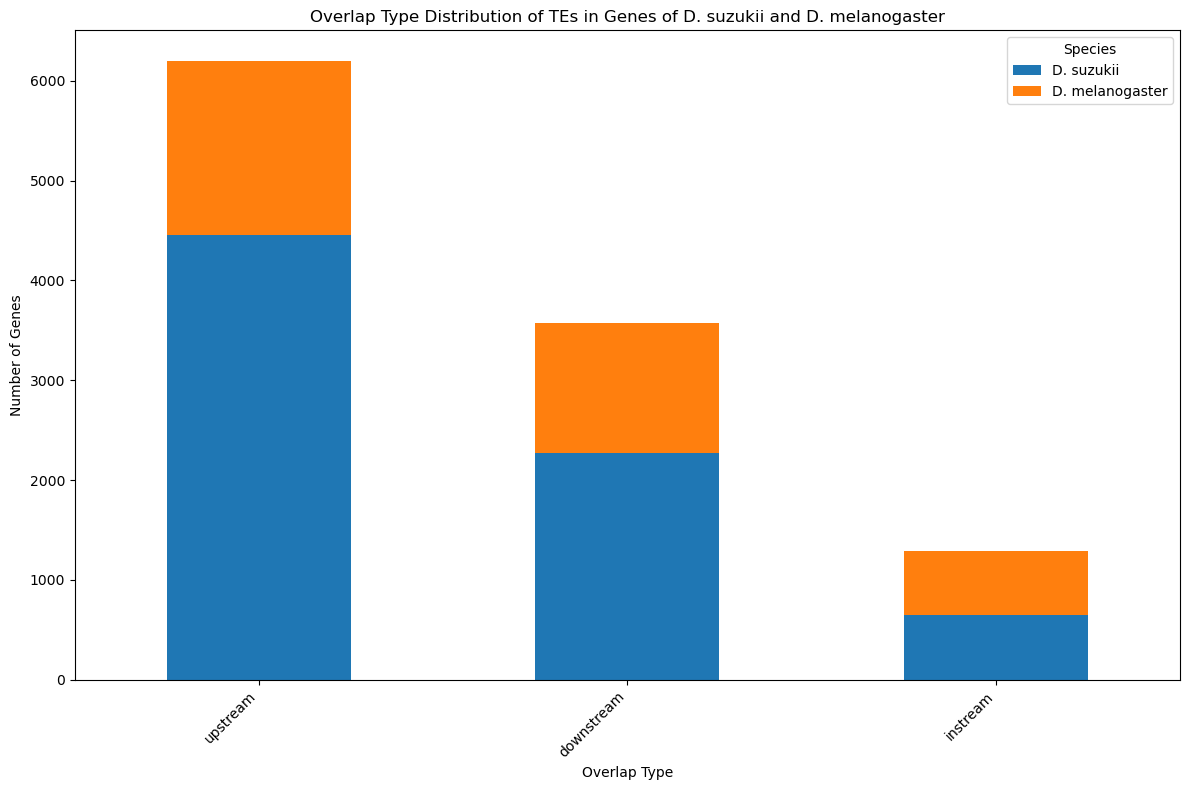

In [22]:
create_stacked_bar_chart(comparison_df)

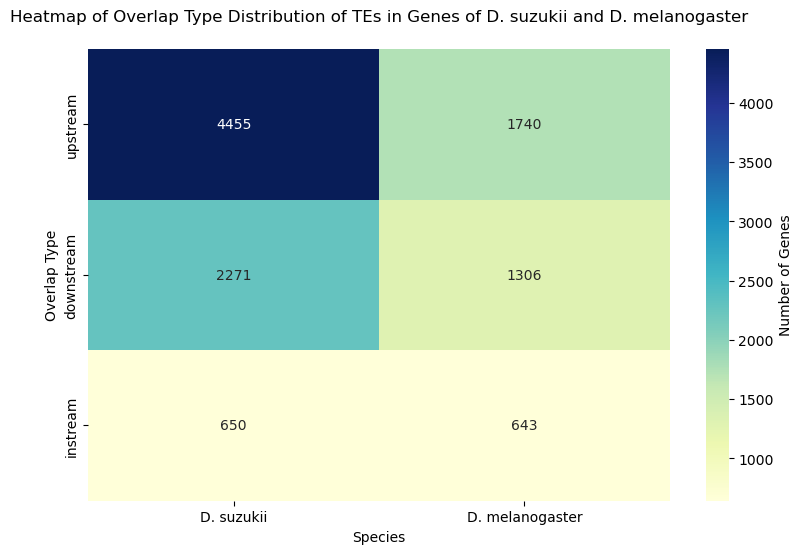

In [23]:
create_heatmap(comparison_df)

In [24]:
temp = comparison_df[
        (comparison_df['overlap_type_suzukii'] != '') &
        (comparison_df['overlap_type_melano'] != '')
    ]
temp = temp.dropna(subset=['overlap_type_suzukii', 'overlap_type_melano'])
print(len(list(set(temp['gene_name'].tolist()))))

2180


In [25]:
def perform_clustering(comparison_df, n_clusters=3):
    # Filtrar el DataFrame para excluir filas vacías o NaN
    filtered_comparison_df = comparison_df.dropna(subset=['overlap_type_suzukii', 'overlap_type_melano'])
    filtered_comparison_df = filtered_comparison_df[
        (filtered_comparison_df['overlap_type_suzukii'] != '') &
        (filtered_comparison_df['overlap_type_melano'] != '')
    ]

    # Crear columnas binarias para presencia (1) o ausencia (0) de TEs
    filtered_comparison_df['suzukii_te_present'] = filtered_comparison_df['te_family_name_suzukii'].apply(lambda x: 1 if x else 0)
    filtered_comparison_df['melano_te_present'] = filtered_comparison_df['te_family_name_melano'].apply(lambda x: 1 if x else 0)

    # Seleccionar las columnas relevantes para el clustering
    features = filtered_comparison_df[['suzukii_te_present', 'melano_te_present']]

    # Aplicar K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    filtered_comparison_df['cluster'] = kmeans.fit_predict(features)

    # Visualizar con un gráfico de dispersión de PCA (análisis de componentes principales)
    pca = PCA(n_components=2)
    components = pca.fit_transform(features)
    filtered_comparison_df['PCA1'] = components[:, 0]
    filtered_comparison_df['PCA2'] = components[:, 1]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=filtered_comparison_df, palette='viridis')
    plt.title('Clustering de Genes Basado en la Presencia de TEs')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

    return filtered_comparison_df

In [26]:
#clustered_df = perform_clustering(comparison_df)

In [27]:
def plot_genes_by_te_class(merged_df):
    # Count the number of genes by TE class for each genome
    suzukii_class_counts = merged_df.groupby('te_class_suzukii')['gene_name'].nunique()
    melano_class_counts = merged_df.groupby('te_class_melano')['gene_name'].nunique()

    # Create a DataFrame with the counts
    class_counts_df = pd.DataFrame({
        'D. suzukii': suzukii_class_counts,
        'D. melanogaster': melano_class_counts
    }).fillna(0)  # Fill with 0 for classes not present in a genome

    # Create a stacked bar chart
    class_counts_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#1f77b4', '#ff7f0e'])

    # Set titles and labels
    plt.title('Number of Genes with TE Presence by Superfamily in D. suzukii and D. melanogaster')
    plt.xlabel('Superfamily')
    plt.ylabel('Number of Genes')
    plt.legend(title='Species')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Save the plot to the specified output path
    plt.savefig('genes_with_te_by_superfamily.png', format='png', dpi=300)
    plt.show()

In [28]:
def plot_te_class_heatmap(merged_df):
    """
    Plots a heatmap to visualize the number of genes with TE presence by superfamily
    in D. suzukii and D. melanogaster.
    
    Parameters:
    merged_df (DataFrame): A DataFrame containing the data with columns for TE classes and gene names.
    """
    # Count the number of genes by TE class for each genome
    suzukii_class_counts = merged_df.groupby('te_class_suzukii')['gene_name'].nunique()
    melano_class_counts = merged_df.groupby('te_class_melano')['gene_name'].nunique()

    # Create a DataFrame with the counts
    class_counts_df = pd.DataFrame({
        'D. suzukii': suzukii_class_counts,
        'D. melanogaster': melano_class_counts
    }).fillna(0)  # Fill with 0 for classes not present in a genome

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(class_counts_df, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Number of Genes'})

    # Set titles and labels
    plt.title('Heatmap of Number of Genes with TE Presence by Superfamily in D. suzukii and D. melanogaster')
    plt.xlabel('Species')
    plt.ylabel('Superfamily')

    # Adjust layout to fit everything properly
    plt.tight_layout()

    # Save the plot to the specified output path
    plt.savefig('genes_with_te_heatmap.png', format='png', dpi=300)
    plt.show()

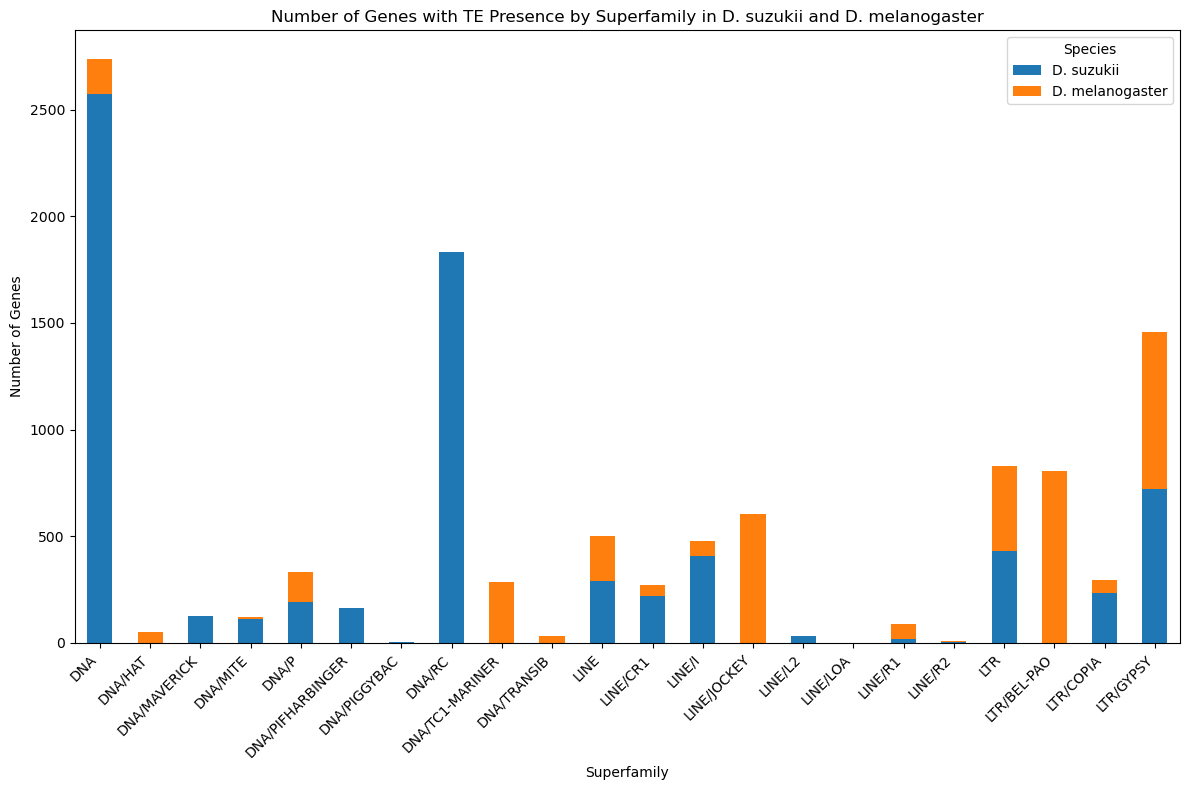

In [29]:
# Usar la función
plot_genes_by_te_class(comparison_df)

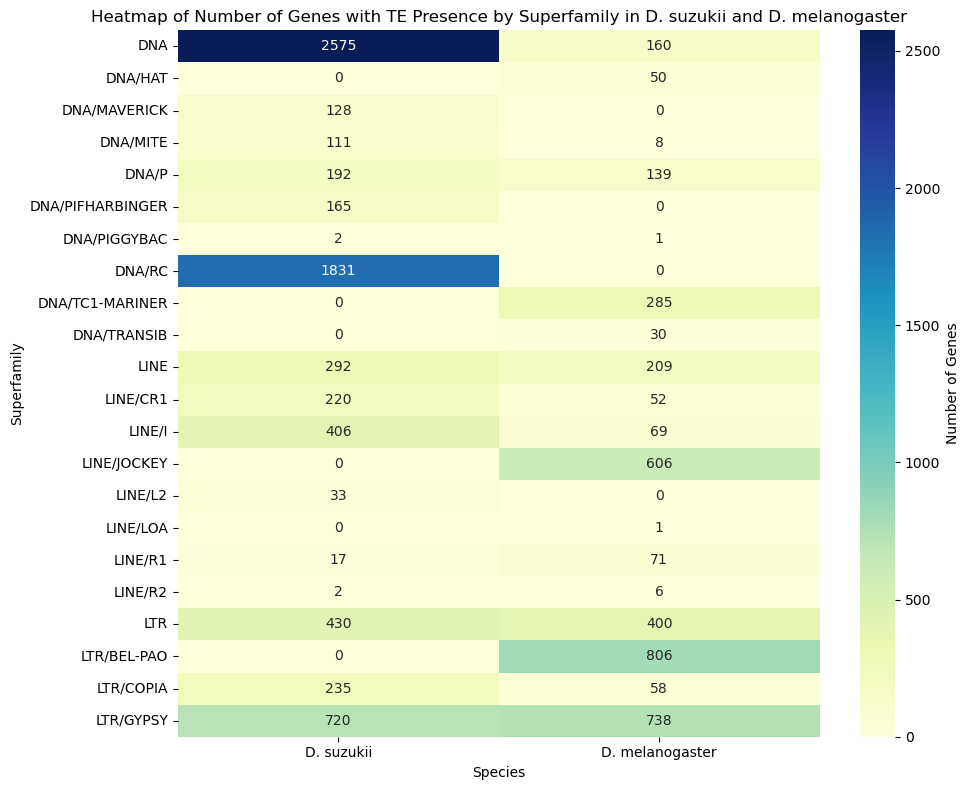

In [30]:
plot_te_class_heatmap(comparison_df)

In [31]:
def plot_overlaps_by_gene(merged_df):
    # Filtrar para eliminar filas sin solapamientos
    overlap_df = merged_df.dropna(subset=['overlap_type_suzukii', 'overlap_type_melano'], how='all')

    # Crear un DataFrame con las columnas relevantes
    overlaps_data = overlap_df[['gene_name', 'overlap_type_suzukii', 'overlap_type_melano', 'te_class_suzukii', 'te_class_melano']]
    
    # Preparar los datos para el gráfico
    overlaps_data = overlaps_data.melt(id_vars='gene_name', value_vars=['overlap_type_suzukii', 'overlap_type_melano'], 
                                       var_name='species', value_name='overlap_type')

    # Eliminar filas donde no hay tipo de solapamiento (overlap)
    overlaps_data = overlaps_data.dropna(subset=['overlap_type'])

    # Crear el gráfico de barras múltiples
    plt.figure(figsize=(14, 8))
    sns.countplot(data=overlaps_data, x='gene_name', hue='overlap_type', dodge=True)
    
    # Configurar los títulos y etiquetas
    plt.title('Tipo de Solapamiento para Cada Gen en D. suzukii y D. melanogaster')
    plt.xlabel('Nombre del Gen')
    plt.ylabel('Cantidad de Solapamientos')
    plt.xticks(rotation=90)
    plt.legend(title='Tipo de Solapamiento')
    plt.tight_layout()
    plt.show()

In [32]:
#plot_overlaps_by_gene(comparison_df)

In [33]:
comparison_final = pd.read_csv('comparison_df.csv')
comparison_final.head()

,gene_name,gene_start_suzukii,gene_end_suzukii,strand_suzukii,te_family_name_suzukii,te_class_suzukii,overlap_type_suzukii,attributes_suzukii,gene_start_melano,gene_end_melano,strand_melano,te_family_name_melano,te_class_melano,overlap_type_melano,attributes_melano,te_family_diff,te_class_diff,overlap_type_diff,has_difference
0,ir21a,45771,48028,-,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CG2657;Dbxref=FLYBASE:FBgn0031209...,21823.0,25155.0,-,NaN,NaN,NaN,ID=gene-Dmel_CG2657;Dbxref=FLYBASE:FBgn0031209...,True,True,True,True
1,asrna:cr43609,45771,48048,+,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CR43609;Dbxref=FLYBASE:FBgn026358...,21952.0,24237.0,+,NaN,NaN,NaN,ID=gene-Dmel_CR43609;Dbxref=FLYBASE:FBgn026358...,True,True,True,True
2,cda5,49477,84204,-,nf_360_HELITRON_1,DNA/RC,upstream,ID=gene-Dmel_CG31973;Dbxref=FLYBASE:FBgn005197...,25402.0,65404.0,-,Jockey-4_DEl,LINE/JOCKEY,instream,ID=gene-Dmel_CG31973;Dbxref=FLYBASE:FBgn005197...,True,True,True,True
3,lncrna:cr46254,78982,79518,+,NaN,NaN,NaN,ID=gene-Dmel_CR46254;Dbxref=FLYBASE:FBgn026798...,54817.0,55767.0,+,Jockey-4_DEl,LINE/JOCKEY,upstream,ID=gene-Dmel_CR46254;Dbxref=FLYBASE:FBgn026798...,True,True,True,True
4,dbr,93118,97575,+,NaN,NaN,NaN,ID=gene-Dmel_CG11371;Dbxref=FLYBASE:FBgn006777...,66482.0,71390.0,+,X-element,LINE/JOCKEY,upstream,ID=gene-Dmel_CG11371;Dbxref=FLYBASE:FBgn006777...,True,True,True,True
